In [1]:
import ml_insights as mli
import numpy as np
import scipy as sp
import pandas as pd
import psycopg2
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)

def flatten(l):
    return [item for sublist in l for item in sublist]

In [3]:
# cell 2: connection
conn = psycopg2.connect(
   database='tradesy',
   port=os.environ['REDSHIFT_PORT'],
   password=os.environ['REDSHIFT_PASS'],
   user=os.environ['REDSHIFT_USER'],
   host=os.environ['REDSHIFT_HOST']
  ) 

In [4]:
query = """
select * from saleability_model_v2 limit 1000
"""


df = pd.read_sql(query, conn)

In [5]:
domain = [u'shipping_price_ratio',
       u'asking_price', u'price_level', u'brand_score', u'a_over_b', u'a',
       u'favorite_count', u'b', u'purchase_count', u'has_blurb', u'has_image',
   u'seasonal_component', u'description_length', u'sold_similarity',
       u'unsold_similarity', u'description_similarity_delta']

In [6]:
categorical_features = [u'has_blurb', u'has_image']

In [7]:
y = df.purchase_dummy
X = df[domain]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)

In [8]:
rf = RandomForestClassifier(n_estimators=250, class_weight='auto')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [9]:
pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print classification_report(y_test, pred)

             precision    recall  f1-score   support

      False       0.90      0.96      0.93       170
       True       0.61      0.37      0.46        30

avg / total       0.85      0.87      0.86       200



In [10]:
#need to convert integers to floats for lime to work
for column in X_train.columns:
    X_train[column] = X_train[column].astype(float)
    X_test[column] = X_test[column].astype(float)

In [11]:
# This took 23 minutes!!!
mxr = mli.ModelXRay(rf, X_train)

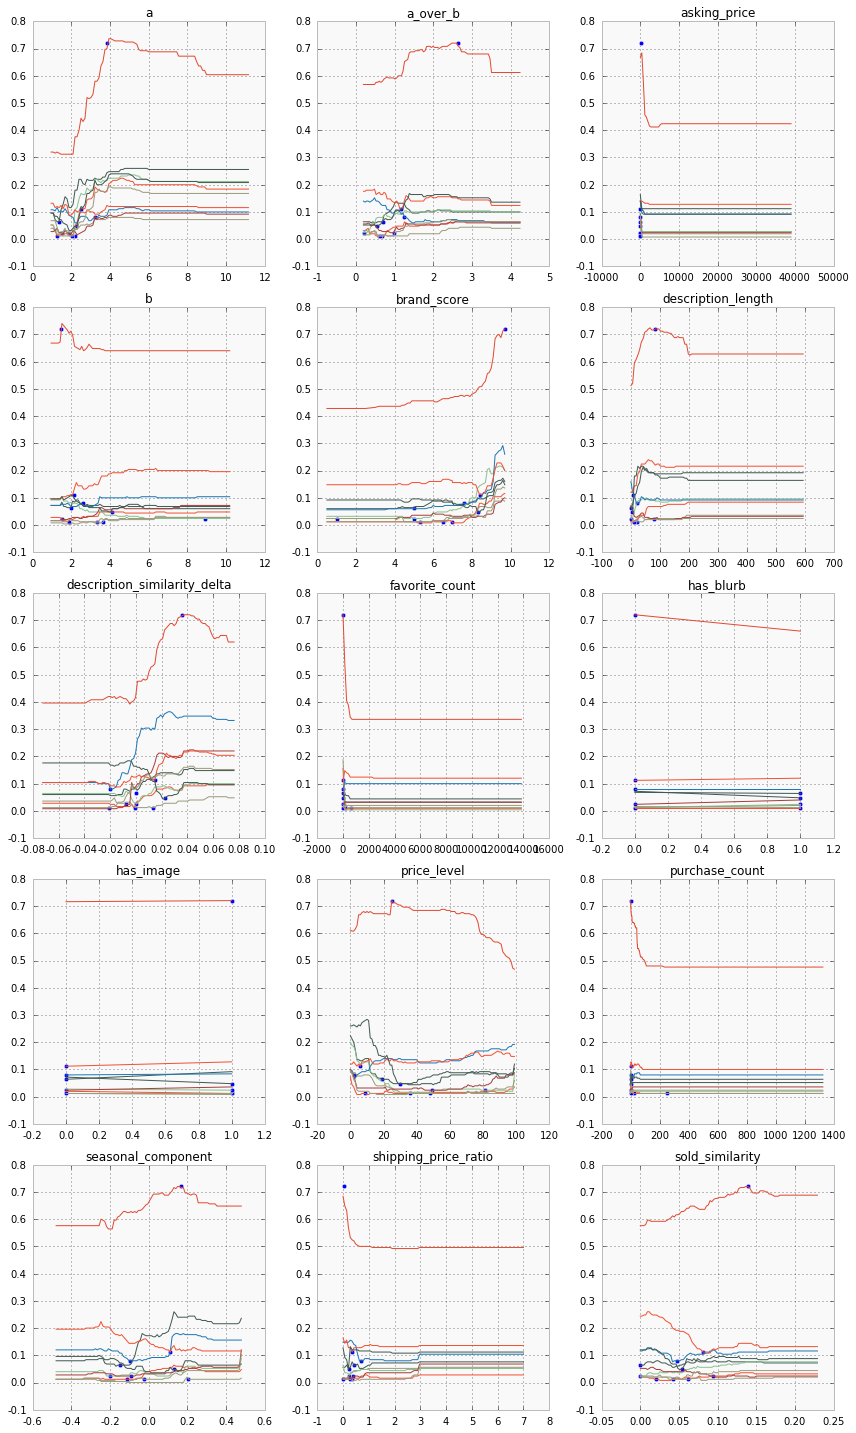

In [23]:
# Partial dependence plots as described in Goldstein (Individual Conditional Expectation plots)
# num_pts = number of observations to plot
# Each line represents effect of varying feature X for that particular observation. Base value is marked by the blue dot.
# Y axis is predicted target
indices = mxr.feature_dependence_plots(num_pts=10)


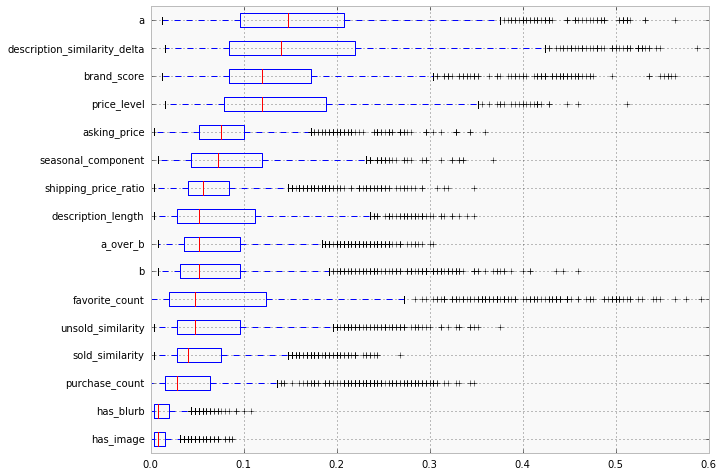

In [21]:
# shows disctribution of feature effects
mxr.feature_effect_summary()

In [22]:
# gven the two points evaluates target in both scenarios and determines which feature creates the largers change in target
# args: index_1, index_2
diff_path_obj = mxr.explain_prediction_difference(193,300, tol=.05)


Your initial point has a target value of 0.86
Your final point has a target value of 0.004
Changing a from 3.92 to 1.5337
		changes your target by -0.448 to 0.412
----------
Changing brand_score from 9.2 to 7.2
		changes your target by -0.176 to 0.236
----------
Changing price_level from 6.0 to 31.0
		changes your target by -0.128 to 0.108
----------
Changing favorite_count from 30.0 to 274.0
		changes your target by -0.06 to 0.048
----------
Changing purchase_count from 3.0 to 67.0
		changes your target by -0.028 to 0.02
----------
Changing a_over_b from 1.3552 to 0.608
		changes your target by -0.012 to 0.008
----------
Changing shipping_price_ratio from 0.0 to 0.25
		changes your target by 0.008 to 0.016
----------
Changing description_length from 25.0 to 8.0
		changes your target by -0.012 to 0.004
----------
Tolerance of 0.05 reached
Current value of 0.004 is within 5.0% of 0.004
